In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from statsmodels.tsa.seasonal import seasonal_decompose
import sys
import os
sys.path.append(os.path.abspath('..'))

In [2]:
raw_analysis = pd.read_csv('../data/raw_analyst_ratings.csv')


**Checking for null variables**

In [3]:
raw_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB


In [4]:
raw_analysis['date'].head()


0    2020-06-05 10:30:54-04:00
1    2020-06-03 10:45:20-04:00
2    2020-05-26 04:30:07-04:00
3    2020-05-22 12:45:06-04:00
4    2020-05-22 11:38:59-04:00
Name: date, dtype: object

**Convert object to datetime** 

In [3]:
raw_analysis['date'] = pd.to_datetime(raw_analysis['date'], format='mixed',utc=True)
raw_analysis.head(10)

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A
5,5,"CFRA Maintains Hold on Agilent Technologies, L...",https://www.benzinga.com/news/20/05/16095163/c...,vishwanath@benzinga.com,2020-05-22 15:23:25+00:00,A
6,6,"UBS Maintains Neutral on Agilent Technologies,...",https://www.benzinga.com/news/20/05/16094027/u...,vishwanath@benzinga.com,2020-05-22 13:36:20+00:00,A
7,7,Agilent Technologies shares are trading higher...,https://www.benzinga.com/wiim/20/05/16093805/a...,Benzinga Newsdesk,2020-05-22 13:07:04+00:00,A
8,8,Wells Fargo Maintains Overweight on Agilent Te...,https://www.benzinga.com/news/20/05/16093505/w...,vishwanath@benzinga.com,2020-05-22 12:37:59+00:00,A
9,9,10 Biggest Price Target Changes For Friday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-05-22 12:06:17+00:00,A


In [7]:
# count headline length
raw_analysis['headline_length'] = raw_analysis['headline'].str.len()

In [4]:
# count each publisher published articles
publisher_counts = raw_analysis['publisher'].value_counts()
publisher_counts.head(20)

publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590
Name: count, dtype: int64

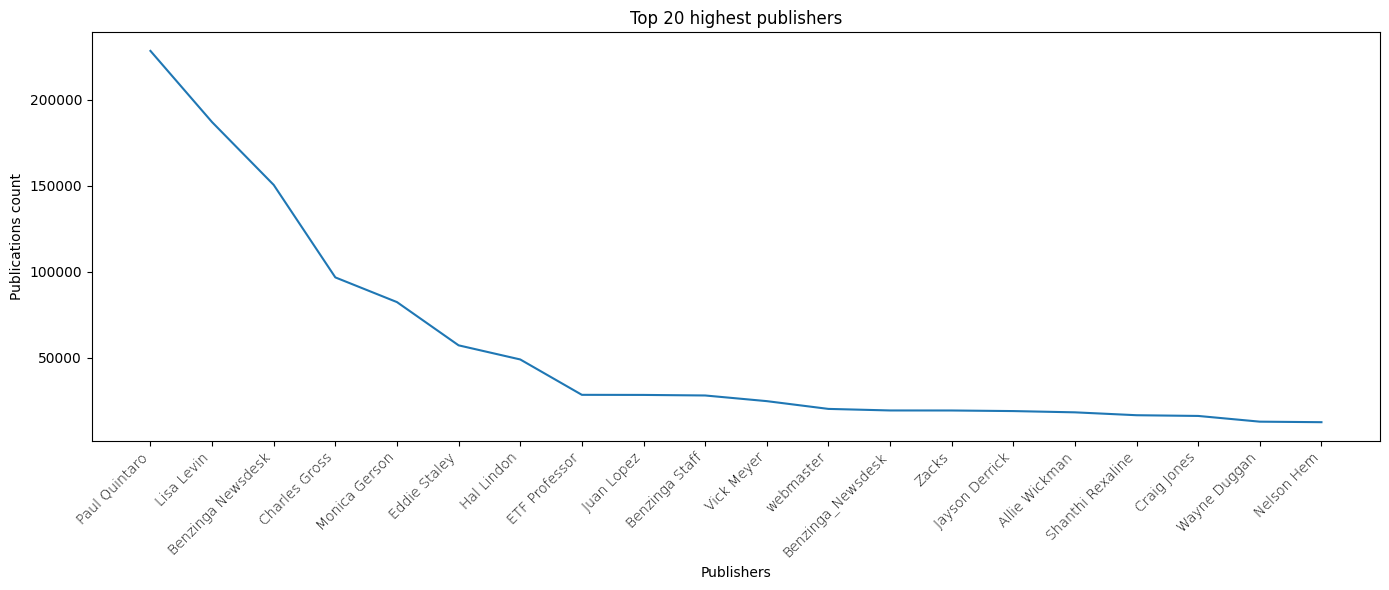

In [15]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=publisher_counts.head(20).index, y=publisher_counts.head(20).values)
plt.title("Top 20 highest publishers")
plt.xlabel('Publishers')
plt.ylabel('Publications count')
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light')
plt.tight_layout()
plt.show()

date
2009-02-14 00:00:00+00:00    1
2009-02-15 00:00:00+00:00    0
2009-02-16 00:00:00+00:00    0
2009-02-17 00:00:00+00:00    0
2009-02-18 00:00:00+00:00    0
2009-02-19 00:00:00+00:00    0
2009-02-20 00:00:00+00:00    0
2009-02-21 00:00:00+00:00    0
2009-02-22 00:00:00+00:00    0
2009-02-23 00:00:00+00:00    0
Freq: D, dtype: int64


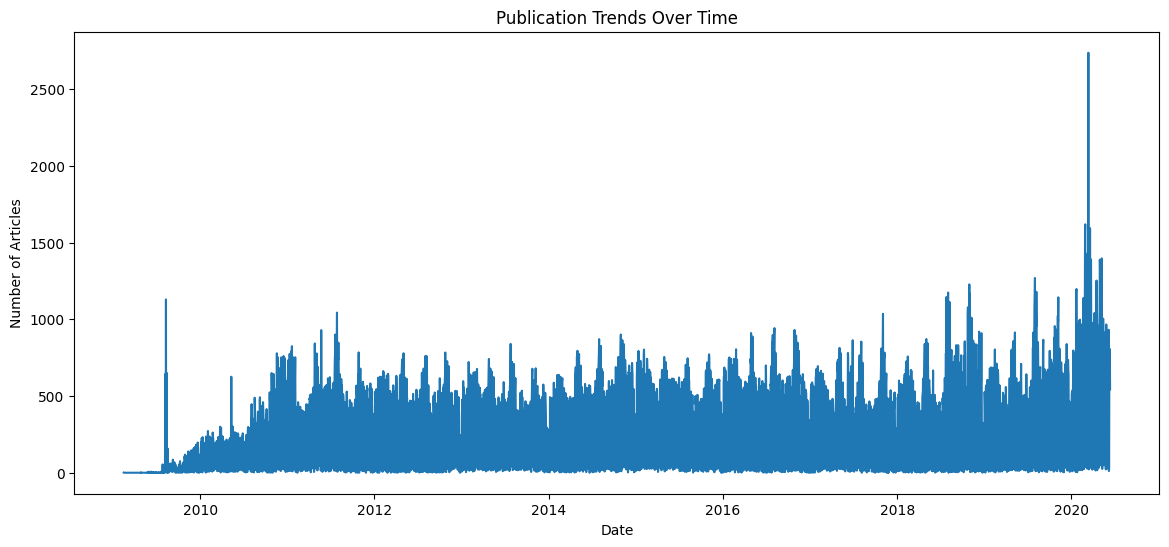

TypeError: Series.sort_index() takes 1 positional argument but 2 were given

In [9]:


# Group by date and count articles
day_counts = raw_analysis.set_index('date').resample('D').size()
print(day_counts.head(10))
plt.figure(figsize=(14, 6))
sns.lineplot(x=day_counts.index, y=day_counts.values)
plt.title('Publication Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')

plt.show()


day_counts.head(10).sort_index(day_counts.values)

### Topic Modeling

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('punkt_tab')

# Preprocess headlines: remove stopwords and tokenize
stop_words = set(stopwords.words('english'))
def preprocess(text):
    tokens = word_tokenize(str(text).lower())
    
    return ' '.join([word for word in tokens if word.isalpha() and word not in stop_words])

raw_analysis['processed_headline'] = raw_analysis['headline'].apply(preprocess)

# Vectorize the processed headlines
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
headline_matrix = vectorizer.fit_transform(raw_analysis['processed_headline'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(headline_matrix)

In [61]:


# Display top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

print_top_words(lda, vectorizer.get_feature_names_out(), 10)

Topic #1:
vs eps est reports sales stocks session moving sees revenue

Topic #2:
earnings estimate announces scheduled shares says update reports analyst deal

Topic #3:
stocks benzinga price target biggest etfs new watch yesterday upgrades

Topic #4:
market stocks earnings stock week lows ahead says morning futures

Topic #5:
shares pt buy update trading maintains raises market downgrades initiates



In [ ]:
feature_name = vectorizer.get_feature_names_out()
for topic_idx, topi in enumerate(lda.components_):
    print([feature_name[i] for i in topi.argsort()[:-10 - 1:-1]])
topic_assignement = lda.transform(headline_matrix).argmax(axis=1)
raw_analysis['topic'] = topic_assignement

['vs', 'eps', 'est', 'reports', 'sales', 'stocks', 'session', 'moving', 'sees', 'revenue']
['earnings', 'estimate', 'announces', 'scheduled', 'shares', 'says', 'update', 'reports', 'analyst', 'deal']
['stocks', 'benzinga', 'price', 'target', 'biggest', 'etfs', 'new', 'watch', 'yesterday', 'upgrades']
['market', 'stocks', 'earnings', 'stock', 'week', 'lows', 'ahead', 'says', 'morning', 'futures']
['shares', 'pt', 'buy', 'update', 'trading', 'maintains', 'raises', 'market', 'downgrades', 'initiates']


/tmp/ipykernel_133029/1183659811.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  topic_time_counts = raw_analysis.groupby([raw_analysis['date'].dt.to_period('D'), 'topic']).size().unstack(fill_value=0)


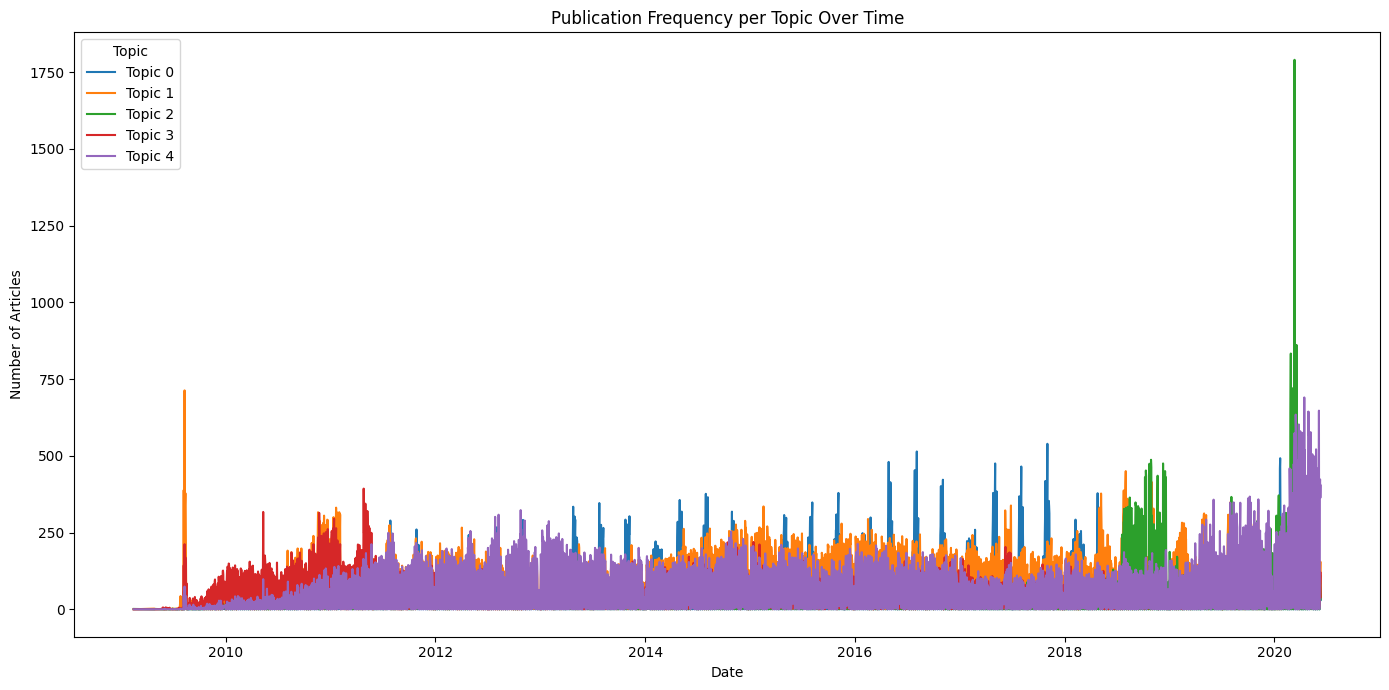

In [ ]:
topic_time_counts = raw_analysis.groupby([raw_analysis['date'].dt.to_period('D'), 'topic']).size().unstack(fill_value=0)
topic_time_counts.index = topic_time_counts.index.to_timestamp()

plt.figure(figsize=(14, 7))
for topic in topic_time_counts.columns:
    plt.plot(topic_time_counts.index, topic_time_counts[topic], label=f"Topic {topic}")
plt.title('Publication Frequency per Topic Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend(title='Topic')
plt.tight_layout()
plt.show()